# GHG accounting scopes
In this notebook we provide a quick method to derive GHG factors for scopes 1, 2, and 3, based on EXIOBASE data. This is based on rough assumptions and broad definitions.
Requirements:
- have module `pymrio` installed,
- file `IOT_2016_ixi.zip`,
- file `characterisation_EXIOBASE3_air_only.xlsx` for the characterization of impacts (i.e. working with CO2 eq. instead of kg CO2).

In [1]:
# Import necessary modules
import pymrio as mr
import pandas as pd

In [2]:
# Parse EXIOBASE3
exio3 = mr.parse_exiobase3(path='./EXIOBASE/exiobase3.4_iot_2011_pxp.zip')

In [3]:
# Include characterization
Q = pd.read_excel('characterisation_EXIOBASE3_air_only.xlsx',
                  sheet_name='Q_satellite_3.7',
                  index_col=[0,1],
                  header=[0,1,2,3])
Q_unit = [i[1] for i in Q.index]

# We want the indices to match exactly
Q.index = exio3.satellite.F.index

In [4]:
# Characterization is not parsed by default in EXIOBASE3 so we need to do it by hand
# same method as in https://github.com/konstantinstadler/pymrio/blob/3a86bda9c7ac4cd7fdfa24932018017801dd30c0/pymrio/tools/ioparser.py

impact = dict()

impact['F'] = Q.T.dot(exio3.satellite.F)
impact['F_Y'] = Q.T.dot(exio3.satellite.F_Y)
impact['unit'] = Q_unit
impact['name'] = 'impact'
exio3.impact = mr.Extension(**impact)

# Test if we find the global GHG emissions (should be around 45 Gt CO2 eq. in 2016)
m = ('Problem oriented approach: baseline (CML, 2001)', 'global warming (GWP100)', 'GWP100 (IPCC, 2007)', 'kg CO2 eq.')
exio3.impact.F.loc[m].sum() + exio3.impact.F_Y.loc[m].sum()

42296316751859.375

In [5]:
# Calculate everything (this crashes half the time, make sure you have enough RAM free)
exio3.calc_all()

In [6]:
# Check that extension "impact" has its own M matrix
exio3.impact.M

region                                                                                                                                                         AT  \
sector                                                                                                                                                 Paddy rice   
Value Added                                     Unnamed: 2_level_1                                 Unnamed: 2_level_2                  M.EUR                  0.0   
Employment                                      Unnamed: 3_level_1                                 Unnamed: 3_level_2                  1000 p.                0.0   
Employment hour                                 Unnamed: 4_level_1                                 Unnamed: 4_level_2                  M.hr                   0.0   
Problem oriented approach: baseline (CML, 2001) abiotic depletion (elements, ultimate ultimate ... ADPelements (Oers et al. 2001)      kg antimony eq.        0.0   
                                                abiotic depletion (fossil fuels)                   ADPfossil fuels (Oers et al., 2001) MJ                     0.0   
...                                                                                                                                                           ...   
Energy Carrier Net TMAR                         Unnamed: 111_level_1                               Unnamed: 111_level_2                MJ                     0.0   
Energy Carrier Net TOTH                         Unnamed: 112_level_1                               Unnamed: 112_level_2                MJ                     0.0   
Energy Carrier Net TRAI                         Unnamed: 113_level_1                               Unnamed: 113_level_2                MJ                     0.0   
Energy Carrier Net TROA                         Unnamed: 114_level_1                               Unnamed: 114_level_2                MJ                     0.0   
Energy Carrier Net LOSS                         Unnamed: 115_level_1                               Unnamed: 115_level_2                MJ                     0.0   

region                                                                                                                                                            \
sector                                                                                                                                                     Wheat   
Value Added                                     Unnamed: 2_level_1                                 Unnamed: 2_level_2                  M.EUR            1.000000   
Employment                                      Unnamed: 3_level_1                                 Unnamed: 3_level_2                  1000 p.          0.033410   
Employment hour                                 Unnamed: 4_level_1                                 Unnamed: 4_level_2                  M.hr             0.079886   
Problem oriented approach: baseline (CML, 2001) abiotic depletion (elements, ultimate ultimate ... ADPelements (Oers et al. 2001)      kg antimony eq.  0.000000   
                                                abiotic depletion (fossil fuels)                   ADPfossil fuels (Oers et al., 2001) MJ               0.000000   
...                                                                                                                                                          ...   
Energy Carrier Net TMAR                         Unnamed: 111_level_1                               Unnamed: 111_level_2                MJ               0.000000   
Energy Carrier Net TOTH                         Unnamed: 112_level_1                               Unnamed: 112_level_2                MJ               0.000000   
Energy Carrier Net TRAI                         Unnamed: 113_level_1                               Unnamed: 113_level_2                MJ               0.000000   
Energy Carrier Net TROA                         Un

Distinguishing the three scopes of GHG accounting is possible with the data we have if we follow the GHG Protocol definition. As we know, Scope 1 encompasses all direct emissions, which corresponds to our S matrix here. Scope 2 is mainly direct emissions due to the direct use of electricity, for those we need to isolate the concerned sectors, and calculate specifically their impact scaled to the transaction between them and each consuming sector (A * S). The rest is Scope 3, namely matrix M minus Scope 1 and Scope 2.

In [7]:
# Scope 1 factors per MEUR
scope1 = exio3.impact.S.loc[m]
scope1

region  sector                                           
AT      Paddy rice                                           0.000000e+00
        Wheat                                                1.090288e+06
        Cereal grains nec                                    9.681750e+05
        Vegetables, fruit, nuts                              9.339631e+04
        Oil seeds                                            4.928304e+05
                                                                 ...     
WM      Membership organisation services n.e.c. (91)         5.803597e+04
        Recreational, cultural and sporting services (92)    1.099885e+05
        Other services (93)                                  3.099437e+05
        Private households with employed persons (95)        1.649566e+04
        Extra-territorial organizations and bodies           0.000000e+00
Name: (Problem oriented approach: baseline (CML, 2001), global warming (GWP100), GWP100 (IPCC, 2007), kg CO2 eq.), Length: 9800,

In [8]:
# Scope 2 sectors need to be defined, let's assume it's all that have "electricity" in their names
scope2_sectors = [c for c in exio3.impact.S.columns if 'electricity' in c[1]]

In [9]:
scope2 = exio3.impact.S[scope2_sectors].dot(exio3.A.loc[scope2_sectors]).loc[m]
scope2

region  sector                                           
AT      Paddy rice                                             0.000000
        Wheat                                                 13.151961
        Cereal grains nec                                     11.226954
        Vegetables, fruit, nuts                               64.681978
        Oil seeds                                              3.692464
                                                                ...    
WM      Membership organisation services n.e.c. (91)         639.119302
        Recreational, cultural and sporting services (92)    689.829520
        Other services (93)                                  587.147068
        Private households with employed persons (95)        447.163326
        Extra-territorial organizations and bodies             0.000000
Name: (Problem oriented approach: baseline (CML, 2001), global warming (GWP100), GWP100 (IPCC, 2007), kg CO2 eq.), Length: 9800, dtype: float64

In [10]:
# Scope 3 is the rest, lifecycle impacts minus direct emissions and direct energy use
# By construction, all values should still be 0 or positive
scope3 = exio3.impact.M.loc[m] - scope1 - scope2
scope3

region  sector                                           
AT      Paddy rice                                                0.000000
        Wheat                                                197340.959945
        Cereal grains nec                                    162445.950691
        Vegetables, fruit, nuts                              100241.901936
        Oil seeds                                             79553.675129
                                                                 ...      
WM      Membership organisation services n.e.c. (91)         679874.181013
        Recreational, cultural and sporting services (92)    638852.483002
        Other services (93)                                  652234.075178
        Private households with employed persons (95)        589034.049936
        Extra-territorial organizations and bodies                0.000000
Name: (Problem oriented approach: baseline (CML, 2001), global warming (GWP100), GWP100 (IPCC, 2007), kg CO2 eq.), Le

In [11]:
scopes = pd.concat([scope1,scope2,scope3,exio3.impact.M.loc[m]], keys=['Scope 1', 'Scope 2', 'Scope 3', 'Total lifecycle'], axis = 1)

In [12]:
# Check if some values are a bit too high
high_outliers = scopes.sort_values('Total lifecycle', ascending=False)[:50]
high_outliers

,,Scope 1,Scope 2,Scope 3,Total lifecycle
region,sector,,,,
WF,Gas Coke,3.427826e+10,7.095472e-04,4.101433e+05,3.427868e+10
WL,Gas Coke,1.406589e+10,3.733446e-05,1.695423e+05,1.406606e+10
BE,Other Hydrocarbons,1.130620e+10,7.846017e+01,2.494531e+05,1.130645e+10
LT,Paddy rice,5.267632e+09,4.179082e+01,6.046317e+04,5.267693e+09
CY,Gasoline Type Jet Fuel,2.362064e+09,1.150274e-01,4.867423e+05,2.362551e+09
LV,Paddy rice,1.942199e+09,4.288244e+00,7.404709e+04,1.942273e+09
BG,N-fertiliser,5.062872e+08,6.040042e-05,1.020642e+06,5.073079e+08
ZA,Electricity by coal,4.987877e+08,0.000000e+00,4.713280e+06,5.035010e+08
ES,"Natural gas and services related to natural gas extraction, excluding surveying",4.818641e+08,5.735283e+01,5.059925e+05,4.823702e+08


In [13]:
# Some weird things appear, a lot of sectors look like they don't consume electricity?
#exio3.A.loc[scope2_sectors,('EE','Mining of iron ores')].sum()

In [14]:
# Or sectors that should not have such big factors
#scopes.loc[(slice(None), 'Production of electricity by tide, wave, ocean'),:]

In [15]:
# Probably because their total output is very small, factors should not be derived for such small amounts
#exio3.x.loc[(slice(None), 'Production of electricity by tide, wave, ocean'),:]

Here France is the only significant producer of tidal electricity (with a 111 M€ output), for which a reasonable factor of about 100 tons GHG per M€ in lifecycle is given. At 18€/MWh production cost, that's 100000 kg GHG/(1000000 € / 18 €/MWh) = 1.8 kg CO2 eq./MWh)

In [16]:
# In fact all our highly-emitting outliers seem to suffer from underrepresentation,
# these sectors do not produce more than 0.5 M€ annually. These factors should not be used.
exio3.x.loc[high_outliers.index]

,,indout
region,sector,
WF,Gas Coke,0.207159
WL,Gas Coke,0.460398
BE,Other Hydrocarbons,0.007475
LT,Paddy rice,0.079144
CY,Gasoline Type Jet Fuel,0.007927
LV,Paddy rice,0.107298
BG,N-fertiliser,0.065769
ZA,Electricity by coal,444.431833
ES,"Natural gas and services related to natural gas extraction, excluding surveying",20.466620


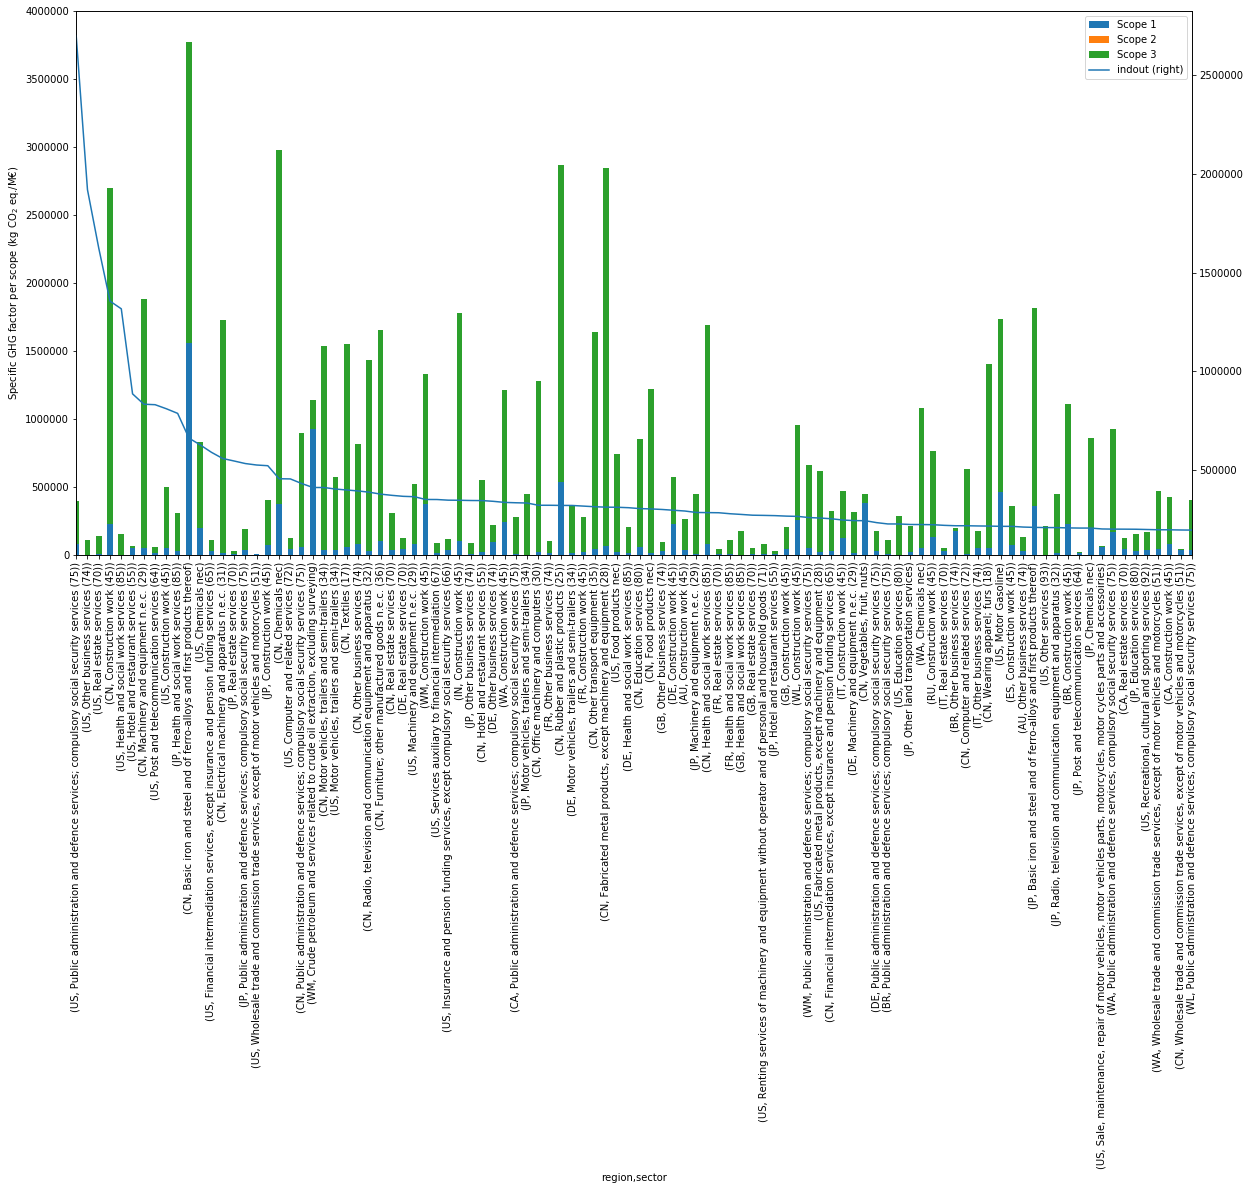

In [17]:
# Let's try to plot the scope breakdown for the top 20 sectors globally
top100 = exio3.x.sort_values(by='indout',ascending=False)[:100].index
ax = scopes.loc[top100,['Scope 1', 'Scope 2', 'Scope 3']].plot(kind='bar',
                                                          stacked=True,
                                                          figsize=(20,10),
                                                          ylim=(0,4e6),
                                                              )
exio3.x.loc[top100].plot(ax=ax,secondary_y=True)
ax.set_ylabel('Specific GHG factor per scope (kg CO$_2$ eq./M€)')
ax.tick_params(axis='x', labelrotation=90)

In [18]:
scopes_final = scopes.copy()
#scopes_final.loc[high_outliers.index] = 0
scopes_final.to_csv('scope.csv')

In [36]:
#exio3.x.loc[(slice(None),'Health and social work services (85)'), :]
exio3.x.loc[('AU','Health and social work services (85)'), :]

indout    111505.489859
Name: (AU, Health and social work services (85)), dtype: float64